### Overview

The AMBRS tools facilitate intercoparison of aerosol box models. The core coponents include (1) the CMake-based *ambuilder* for consistent model building, (2) the Python-based *amdriver* for automated generation of unified numerical experiments, and (3) the Python-based *pyparticle* package for standardization of model output and downstream analysis.

This notebook describes the steps to build, run, and analyze the AMBRS models.

### Step 1: Build supported models via AMBuilder

Build all box models via [AMbuilder](https://github.com/AMBRS-project/ambuilder)

Install additional AMBRS dependencies via:
```
pip install -r requirements.txt
```

### Step 2: Run comparible simulation experiments with the AMBRS driver  

In [ ]:
# -----------------------------------------------------------
# Import modules
# -----------------------------------------------------------
import os
import logging
from math import log10
from pathlib import Path

import numpy as np
import scipy.stats as stats

import ambrs
from pathlib import Path

# -----------------------------------------------------------
# Configure simualtions
# -----------------------------------------------------------

n = 5        # number of ensemble members
n_part = 2000  # PartMC particles per run

dt = 60      # timestep [s]
nstep = 60   # 60 min run

p0 = 101325  # reference pressure [Pa]
h0 = 500     # reference height [m]

# -----------------------------------------------------------
# Make directories for simulation output
# -----------------------------------------------------------
ensemble_name = str(int(dt*nstep/60)) + "min_" + str(n) + "particles"
repo_root = Path.cwd().resolve()
root_dir =  repo_root / "runs" 
ensemble_dir =  root_dir / ensemble_name
partmc_dir = os.path.join(ensemble_dir, "partmc_runs")
mam4_dir = os.path.join(ensemble_dir, "mam4_runs")

for d in [root_dir, ensemble_dir, partmc_dir, mam4_dir]:
    os.makedirs(d, exist_ok=True)


# -----------------------------------------------------------
# Define species
# -----------------------------------------------------------
so4 = ambrs.AerosolSpecies("SO4", molar_mass=96., density=1800., hygroscopicity=0.65)
pom = ambrs.AerosolSpecies("OC", molar_mass=12.01, density=1000., hygroscopicity=0.001)
soa = ambrs.AerosolSpecies("MSA", molar_mass=40., density=2600., hygroscopicity=0.53)
bc  = ambrs.AerosolSpecies("BC",  molar_mass=12.01, density=1800., hygroscopicity=0.)
dst = ambrs.AerosolSpecies("OIN", molar_mass=135.065, density=2600., hygroscopicity=0.1)
na  = ambrs.AerosolSpecies("Na",  molar_mass=23., density=2200., hygroscopicity=0.53)
cl  = ambrs.AerosolSpecies("Cl",  molar_mass=35.5, density=2200., hygroscopicity=0.53)
ncl = na
h2o = ambrs.AerosolSpecies("H2O", molar_mass=18., density=1000., ions_in_soln=1)

so2   = ambrs.GasSpecies("SO2", molar_mass=64.07)
h2so4 = ambrs.GasSpecies("H2SO4", molar_mass=98.079)

# -----------------------------------------------------------
# Define aerosol processes
# -----------------------------------------------------------
processes = ambrs.AerosolProcesses(
    coagulation=False,
    condensation=False,
)

# -----------------------------------------------------------
# Ensemble specification
# -----------------------------------------------------------

# fixme: MAM4 GMDs and GSDs taken from MAM_box_model/box_model_utils/rad_constituents.f90
spec = ambrs.EnsembleSpecification(
    name=ensemble_name,
    aerosols=(so4, pom, soa, bc, dst, ncl, h2o),
    gases=(so2, h2so4),
    size=ambrs.AerosolModalSizeDistribution(modes=[
        ambrs.AerosolModeDistribution(
            name="accumulation",
            species=[so4, pom, soa, bc, dst, ncl],
            number=stats.uniform(1e7, 1e10),
            geom_mean_diam=stats.rv_discrete(values=([1.1e-7], [1.])),
            log10_geom_std_dev=log10(1.8),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # POM
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # BC
                stats.rv_discrete(values=([0.], [1.])),  # DST
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="aitken",
            species=[so4, soa, ncl],
            number=stats.uniform(1e7, 1e11),
            geom_mean_diam=stats.rv_discrete(values=([2.6e-8], [1.])),
            log10_geom_std_dev=log10(1.6),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="coarse",
            species=[dst, ncl, so4, bc, pom, soa],
            number=stats.uniform(1e6, 1e7),
            geom_mean_diam=stats.rv_discrete(values=([2e-6], [1.])),
            log10_geom_std_dev=log10(1.8),
            mass_fractions=[
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="primary carbon",
            species=[pom, bc],
            number=stats.rv_discrete(values=([0.], [1.])),
            geom_mean_diam=stats.loguniform(1e-8, 5e-8),
            log10_geom_std_dev=log10(1.6),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # POM
                stats.rv_discrete(values=([0.], [1.])),  # BC
            ],
        ),
    ]),
    gas_concs=tuple([stats.rv_discrete(values=([0.], [1.])), stats.uniform(1e-10, 1e-8)]),
    #gas_concs=tuple([stats.uniform(1e-10, 1e-8) for _ in range(2)]),
    flux=stats.uniform(1e-11, 1e-8), # not doing anything
    relative_humidity=stats.rv_discrete(values=([0.], [1.])),
    #relative_humidity=stats.uniform(0, 0.99),
    temperature=stats.uniform(240, 70),
    pressure=p0,
    height=h0,
)



/var/folders/jp/b3sqqpxs5szgy6f4g6s2v3180000gn/T/ipykernel_56277/504769250.py:116: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax4.set_xlim(np.min(vals), np.max(vals))


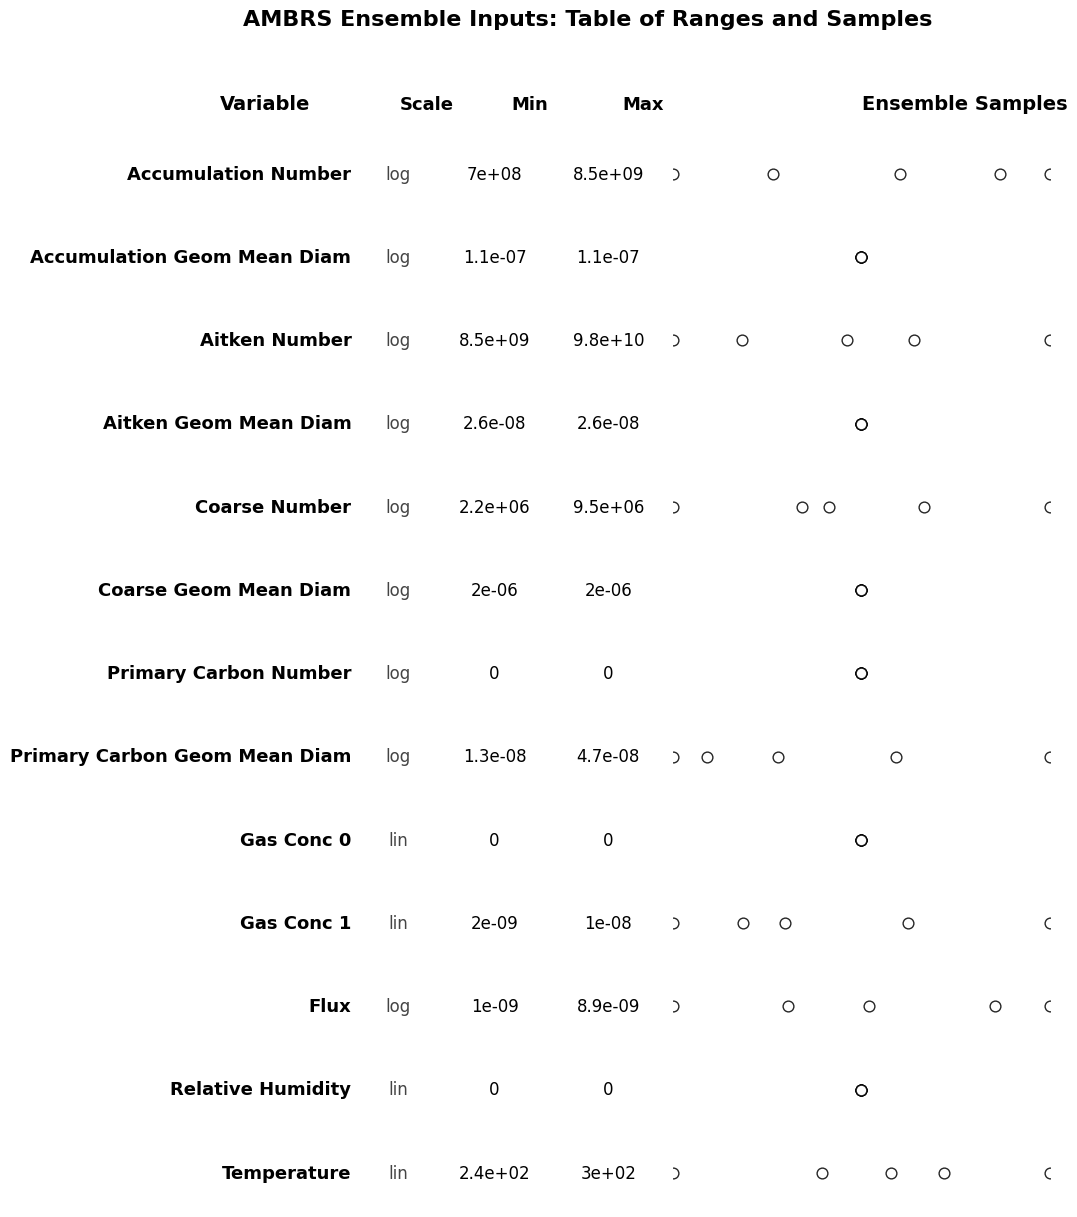

In [2]:
# -----------------------------------------------------------
# Create ensemble
# -----------------------------------------------------------
ensemble = ambrs.lhs(specification=spec, n=n)
scenario_names = [str(ii).zfill(1) for ii in range(1, len(ensemble.flux)+1)]

"""
AMBRS Ensemble Inputs: Figure Table with Ranges and Strip Plots (Linear Scale)
- Table columns: variable name | scale (log/lin) | min | max | strip plot (no text/labels)
- All strip plots on linear scale for visual comparability; no axis, ticks, or text.
- Clean, publication-ready layout.

Usage: Run after ensemble creation in demo.py.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Collect sampled data ---
records = []
scale_info = {}

for i, sample in enumerate(ensemble):
    for mode_idx, mode in enumerate(sample.size.modes):
        mode_base = mode.name.replace(" ", "_")
        records.append({"sample": i, "variable": f"{mode_base}_number", "value": mode.number})
        scale_info[f"{mode_base}_number"] = "log"
        records.append({"sample": i, "variable": f"{mode_base}_geom_mean_diam", "value": mode.geom_mean_diam})
        scale_info[f"{mode_base}_geom_mean_diam"] = "log"
        records.append({"sample": i, "variable": f"{mode_base}_log10_geom_std_dev", "value": mode.log10_geom_std_dev})
        scale_info[f"{mode_base}_log10_geom_std_dev"] = "lin"
        for sp_idx, mf in enumerate(mode.mass_fractions):
            records.append({"sample": i, "variable": f"{mode_base}_mass_fraction_sp{sp_idx}", "value": mf})
            scale_info[f"{mode_base}_mass_fraction_sp{sp_idx}"] = "lin"
    for g_idx, gc in enumerate(sample.gas_concs):
        records.append({"sample": i, "variable": f"gas_conc_{g_idx}", "value": gc})
        scale_info[f"gas_conc_{g_idx}"] = "lin"
    records.append({"sample": i, "variable": "flux", "value": sample.flux})
    scale_info["flux"] = "log"
    records.append({"sample": i, "variable": "relative_humidity", "value": sample.relative_humidity})
    scale_info["relative_humidity"] = "lin"
    records.append({"sample": i, "variable": "temperature", "value": sample.temperature})
    scale_info["temperature"] = "lin"

df = pd.DataFrame(records)

# --- Select variables for table ---
variables_to_plot = [
    "accumulation_number",
    "accumulation_geom_mean_diam",
    "aitken_number",
    "aitken_geom_mean_diam",
    "coarse_number",
    "coarse_geom_mean_diam",
    "primary_carbon_number",
    "primary_carbon_geom_mean_diam",
    "gas_conc_0",
    "gas_conc_1",
    "flux",
    "relative_humidity",
    "temperature",
]

df_plot = df[df["variable"].isin(variables_to_plot)]

# --- Figure table layout ---
n_vars = len(variables_to_plot)
fig_height = 0.85 * n_vars + 1.2
fig = plt.figure(figsize=(11, fig_height))
gs = GridSpec(n_vars+1, 5, width_ratios=[2.7, 1.1, 1.7, 1.7, 6.5], height_ratios=[0.6]+[1]*n_vars)
fig.patch.set_facecolor('white')

# Table header
ax_title = fig.add_subplot(gs[0,:])
ax_title.axis('off')
ax_title.text(0.03, 0.5, "Variable", ha="left", va="center", fontsize=14, fontweight="bold")
ax_title.text(0.24, 0.5, "Scale", ha="left", va="center", fontsize=13, fontweight="bold")
ax_title.text(0.37, 0.5, "Min", ha="left", va="center", fontsize=13, fontweight="bold")
ax_title.text(0.50, 0.5, "Max", ha="left", va="center", fontsize=13, fontweight="bold")
ax_title.text(0.78, 0.5, "Ensemble Samples", ha="left", va="center", fontsize=14, fontweight="bold")

for i, var in enumerate(variables_to_plot):
    vals = df_plot[df_plot["variable"] == var]["value"].values

    # --- Variable name cell
    ax0 = fig.add_subplot(gs[i+1, 0])
    ax0.axis('off')
    ax0.text(1.0, 0.5, var.replace("_", " ").title(), ha="right", va="center", fontsize=13, fontweight="bold")

    # --- Scale cell
    ax1 = fig.add_subplot(gs[i+1, 1])
    ax1.axis('off')
    ax1.text(0.5, 0.5, scale_info[var], ha="center", va="center", fontsize=12, color="#444")

    # --- Min cell
    ax2 = fig.add_subplot(gs[i+1, 2])
    ax2.axis('off')
    ax2.text(0.5, 0.5, f"{np.min(vals):.2g}", ha="center", va="center", fontsize=12)

    # --- Max cell
    ax3 = fig.add_subplot(gs[i+1, 3])
    ax3.axis('off')
    ax3.text(0.5, 0.5, f"{np.max(vals):.2g}", ha="center", va="center", fontsize=12)

    # --- Strip plot cell (no text, no axes)
    ax4 = fig.add_subplot(gs[i+1, 4])
    ax4.scatter(vals, np.ones_like(vals), s=60, facecolor="white", edgecolor="black", alpha=0.85)
    ax4.set_yticks([])
    ax4.set_xticks([])
    for spine in ['top','right','left','bottom']:
        ax4.spines[spine].set_visible(False)
    ax4.set_ylabel("")
    ax4.set_xlabel("")
    ax4.set_xlim(np.min(vals), np.max(vals))

fig.suptitle("AMBRS Ensemble Inputs: Table of Ranges and Samples", fontsize=16, fontweight="bold", x=0.55, y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [3]:
# -----------------------------------------------------------
# Plot helper: horizontal range bars + strip overlay
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

def plot_range_bars(
    df, variables, var_col='variable', value_col='value',
    scale_info=None, highlight_idx=None, highlight_colors=None,
    figsize=(8, None)
):
    """
    Plot variable ranges as horizontal bars with strip plot overlay.
    df must have columns [var_col, value_col, 'sample'].
    """
    n = len(variables)
    fig_h = max(3, 0.45*n + 0.8)
    if figsize[1] is None:
        figsize = (figsize[0], fig_h)

    fig, axs = plt.subplots(n, 1, figsize=figsize, gridspec_kw={'height_ratios':[1]*n})
    if n == 1:
        axs = [axs]

    for ax, var in zip(axs, variables):
        sub = df[df[var_col] == var]
        vals = sub[value_col].to_numpy()
        samples = sub['sample'].to_numpy()

        if len(vals) == 0:
            ax.text(0.5, 0.5, 'No samples', ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            continue

        vmin, vmax = np.nanmin(vals), np.nanmax(vals)
        pad = 0.02*(vmax-vmin) if vmin != vmax else 0.1

        # range bar
        ax.hlines(0.5, vmin, vmax, linewidth=3, color='0.4', zorder=1)

        # strip (grey background)
        ax.scatter(vals, np.full_like(vals, 0.5), s=38,
                   facecolor="0.6", edgecolor="white", lw=0.7, alpha=0.6, zorder=2)

        # highlights
        if highlight_idx is not None:
            if isinstance(highlight_colors, dict):
                for idx in highlight_idx:
                    color = highlight_colors.get(idx, "red")
                    mask = samples == idx
                    ax.scatter(vals[mask], np.full(mask.sum(), 0.5),
                               s=100, color=color, edgecolor='k', zorder=3)
            else:
                colors = highlight_colors or ["red"]*len(highlight_idx)
                for idx, color in zip(highlight_idx, colors):
                    mask = samples == idx
                    ax.scatter(vals[mask], np.full(mask.sum(), 0.5),
                               s=100, color=color, edgecolor='k', zorder=3)

        # scaling
        if scale_info and scale_info.get(var, "lin") == "log":
            ax.set_xscale("log")
            ax.set_xlim(max(vmin, np.nextafter(0, 1)), vmax*1.1 if vmax > 0 else 1)
        else:
            ax.set_xlim(vmin - pad, vmax + pad)
        
        print(vmin,vmax)
        # tidy
        ax.set_yticks([]); ax.set_xticks([])
        ax.text(vmin, -0.18, f"{vmin:.2g}", transform=ax.get_xaxis_transform(),
                ha='left', va='top', fontsize=9)
        ax.text(vmax, -0.18, f"{vmax:.2g}", transform=ax.get_xaxis_transform(),
                ha='right', va='top', fontsize=9)
        ax.set_ylabel(var, rotation=0, ha="right", va="center",
                      fontsize=10, fontweight="bold")
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    return fig


# -----------------------------------------------------------
# Build a tidy table from the ensemble (model-agnostic)
# -----------------------------------------------------------
import numpy as np
import pandas as pd

def _as_array(x, n):
    """
    Return a length-n array:
    - if x is scalar -> fill
    - if x is list/tuple/np.ndarray of length n -> np.asarray(x)
    - else -> None (skip)
    """
    if np.isscalar(x):
        return np.full(n, x, dtype=float)
    try:
        arr = np.asarray(x)
        if arr.shape == (n,):
            return arr.astype(float)
    except Exception:
        pass
    return None

def build_input_ranges_dataframe(
    ensemble,
    *,
    variables=None,
    gas_names=None,
    sample_ids=None,
):
    """
    Create a long-form DataFrame with columns [variable, value, sample]
    directly from an Ensemble produced by ambrs.lhs(...).

    Parameters
    ----------
    ensemble : object
        Must expose per-sample arrays like ensemble.temperature, ensemble.relative_humidity, etc.
    variables : dict[str, str] or None
        Mapping {label -> attribute_name} to extract from `ensemble`.
        Example: {"Temperature (K)": "temperature", "RH": "relative_humidity"}
        If None, tries sensible defaults when present.
    gas_names : list[str] or None
        Names for gas species columns to extract from `ensemble.gas_concs`.
        Accepts either shape (n, n_gas) or iterable of length n_gas with each entry shape (n,).
    sample_ids : array-like or None
        Per-sample identifiers. If None, uses 1..n (int).
    """
    # infer n from the first array-like attribute we can find
    candidates = [
        getattr(ensemble, "relative_humidity", None),
        getattr(ensemble, "temperature", None),
        getattr(ensemble, "flux", None),
        getattr(ensemble, "pressure", None),
    ]
    n = None
    for c in candidates:
        if c is not None:
            try:
                n = len(c)
                break
            except Exception:
                pass
    if n is None:
        raise ValueError("Could not infer ensemble size `n` from standard attributes.")

    if sample_ids is None:
        sample_ids = np.arange(1, n+1, dtype=int)

    # default variables if not provided
    if variables is None:
        variables = {}
        for label, attr in [
            ("Temperature (K)", "temperature"),
            ("Relative humidity", "relative_humidity"),
            ("Pressure (Pa)", "pressure"),
            ("Flux", "flux"),
        ]:
            if hasattr(ensemble, attr):
                variables[label] = attr

    rows = []

    # top-level scalar/array attributes
    for label, attr in variables.items():
        arr = _as_array(getattr(ensemble, attr), n)
        if arr is not None:
            for s, v in zip(sample_ids, arr):
                rows.append({"variable": label, "value": float(v), "sample": int(s)})

    # gas concentrations (if requested and present)
    if gas_names and hasattr(ensemble, "gas_concs"):
        gas = getattr(ensemble, "gas_concs")
        # try (n, n_gas)
        try:
            g = np.asarray(gas)
            if g.ndim == 2 and g.shape[0] == n and g.shape[1] == len(gas_names):
                for j, name in enumerate(gas_names):
                    for s, v in zip(sample_ids, g[:, j]):
                        rows.append({"variable": f"{name} (mixing ratio)", "value": float(v), "sample": int(s)})
            else:
                raise Exception
        except Exception:
            # try iterable of length n_gas with each entry shape (n,)
            try:
                series = [np.asarray(x) for x in gas]
                if len(series) == len(gas_names) and all(len(x) == n for x in series):
                    for name, vec in zip(gas_names, series):
                        for s, v in zip(sample_ids, vec):
                            rows.append({"variable": f"{name} (mixing ratio)", "value": float(v), "sample": int(s)})
            except Exception:
                pass  # silently ignore if structure is unknown

    return pd.DataFrame(rows, columns=["variable", "value", "sample"])


244.67299454663552 297.40065660260507
0.0 0.0
101325.0 101325.0
9.961117201504555e-10 8.891943220355996e-09
0.0 0.0
1.959271236060729e-09 1.0028390485017092e-08


/var/folders/jp/b3sqqpxs5szgy6f4g6s2v3180000gn/T/ipykernel_56277/2739704565.py:62: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")
/var/folders/jp/b3sqqpxs5szgy6f4g6s2v3180000gn/T/ipykernel_56277/2739704565.py:79: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


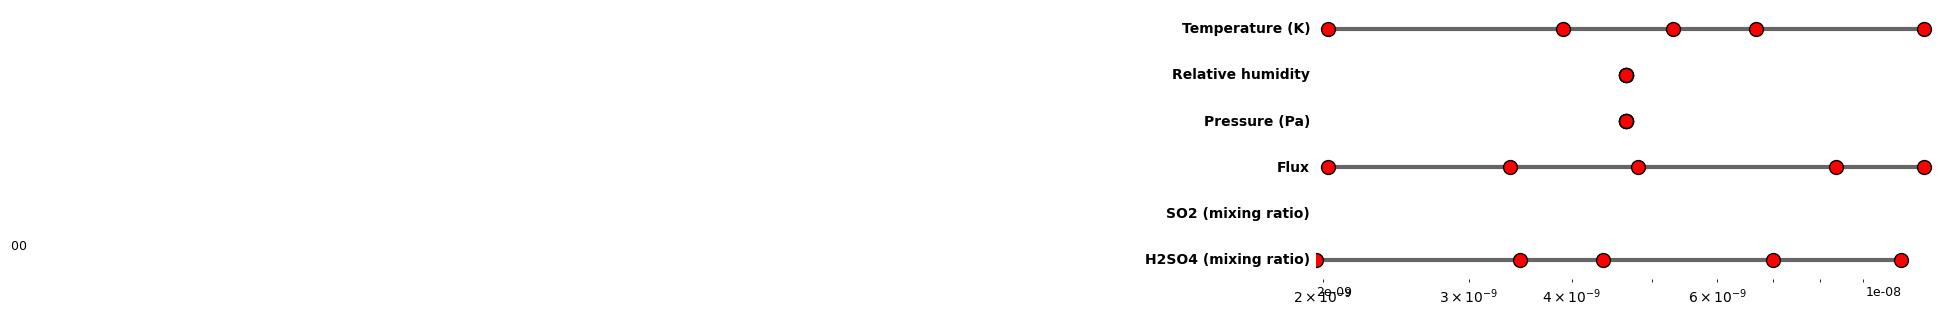

In [4]:
# -----------------------------------------------------------
# INPUT RANGES (from Ensemble) — run this BEFORE launching models
# -----------------------------------------------------------

# If you want to highlight specific scenarios: use integer ids (1..n)
highlight = range(1, n+1)  # highlight all
# highlight = sran if n >= 1 else []
# highlight_color = _scenario_colors(n_rows, palette=colors)
# highlight_colors = ["tab:blue"]

# choose variables (labels on y-axis) -> ensemble attributes
vars_map = {
    "Temperature (K)": "temperature",
    "Relative humidity": "relative_humidity",
    "Pressure (Pa)": "pressure",   # will be flat if scalar in spec
    "Flux": "flux",
}

# gas names (order must match how ensemble.gas_concs is stored)
gas_names = ["SO2", "H2SO4"]

df_input = build_input_ranges_dataframe(
    ensemble,
    variables=vars_map,
    gas_names=gas_names,
    sample_ids=np.arange(1, len(ensemble.flux) + 1, dtype=int),
)

# choose which rows to show and any log axes
variables_to_plot = list(vars_map.keys()) + [f"{g} (mixing ratio)" for g in gas_names]
scale = {f"{g} (mixing ratio)": "log" for g in gas_names}  # optional

_ = plot_range_bars(
    df=df_input,
    variables=variables_to_plot,
    scale_info=scale,
    highlight_idx=highlight,
    # highlight_colors=highlight_colors,
    figsize=(8, None),
)
plt.show()


In [5]:
# -----------------------------------------------------------
# Run MAM4
# -----------------------------------------------------------
mam4 = ambrs.mam4.AerosolModel(processes=processes)
mam4_inputs = mam4.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
mam4_runner = ambrs.PoolRunner(
    model=mam4,
    executable="mam4",
    root=mam4_dir,
    num_processes=1,
)
mam4_runner.run(mam4_inputs)

# -----------------------------------------------------------
# Run PartMC
# -----------------------------------------------------------
partmc = ambrs.partmc.AerosolModel(
    processes=processes,
    run_type="particle",
    n_part=n_part,
    n_repeat=1,
)
partmc_inputs = partmc.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
partmc_runner = ambrs.PoolRunner(
    model=partmc,
    executable="partmc",
    root=partmc_dir,
    num_processes=1,
)
partmc_runner.run(partmc_inputs)


mam4: one or more existing scenario directories found. Overwriting contents...
partmc: one or more existing scenario directories found. Overwriting contents...


### Step 3: Analyze and vizualize model output with pyparticle    

KeyboardInterrupt: 

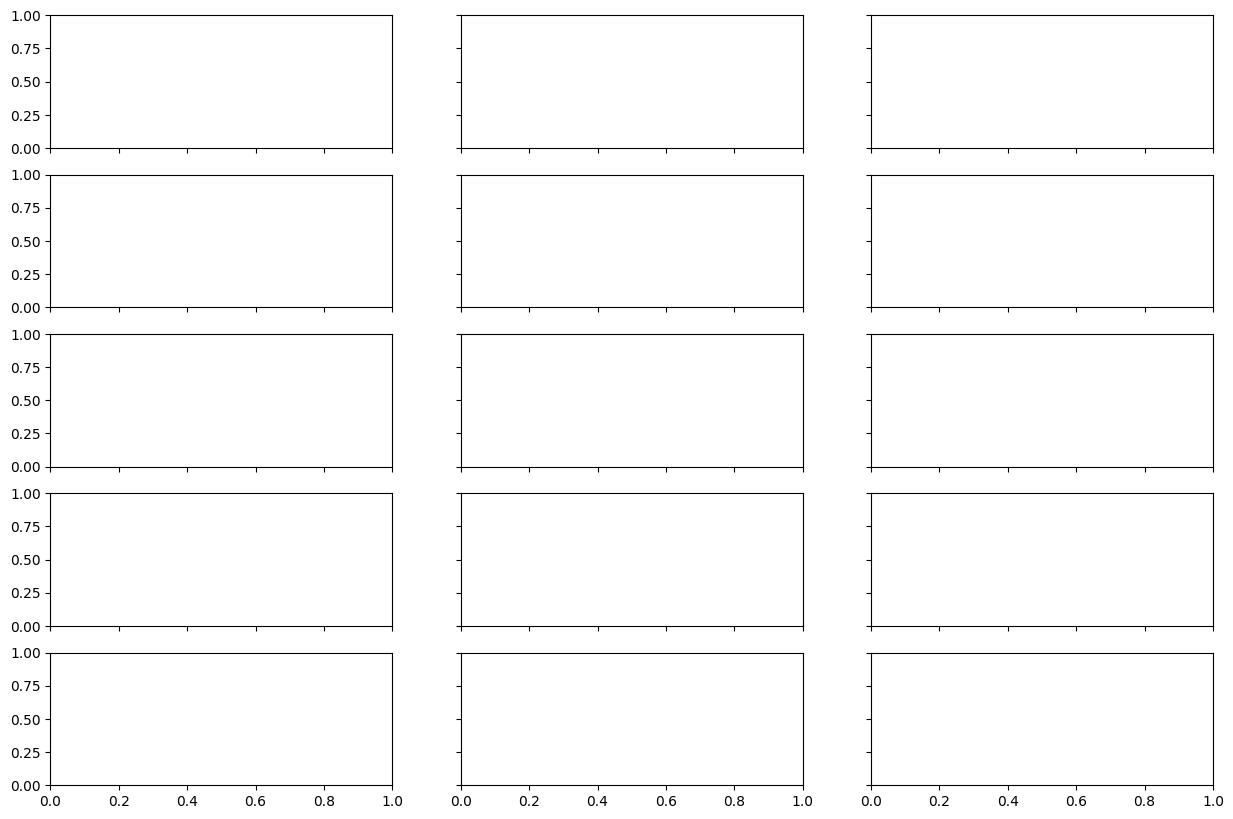

In [6]:
import matplotlib.pyplot as plt

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter
import matplotlib.pyplot as plt
import numpy as np

timesteps = [1, 31, 61]
scenario_names = [str(ii).zfill(1) for ii in range(1, n+1)]
scenarios = scenario_names

# fixme: wrap this in viz module?
fig,ax = plt.subplots(len(scenarios), len(timesteps), figsize=(15,10), squeeze=False, sharex=True, sharey=True)
for i, scenario_name in enumerate(scenarios):
    for j, timestep_to_plot in enumerate(timesteps):
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=mam4_dir,
        )

        # -----------------------------------------------------------
        # Standardized outputs are used for downstream analysis and visualization
        # -----------------------------------------------------------

        mgr = StyleManager(Theme(), deterministic=False)

        # Lines
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4", "population": mam4_output.particle_population, "label": "MAM4"},
        ]

        print('Ntot, partmc:', partmc_output.particle_population.get_Ntot())
        print('Ntot, mam4:', mam4_output.particle_population.get_Ntot())

        # print('tot dry mass, partmc:', partmc_output.particle_population.get_tot_dry_mass())
        # print('tot dry mass, mam4:', mam4_output.particle_population.get_tot_dry_mass())

        # print('tot mass, partmc:', partmc_output.particle_population.get_tot_mass())
        # print('tot mass, mam4:', mam4_output.particle_population.get_tot_mass())

        print('mass SO4, partmc:', np.sum(np.sum(partmc_output.particle_population.spec_masses,axis=1)*partmc_output.particle_population.num_concs))
        print('mass SO4, mam4:', np.sum(np.sum(mam4_output.particle_population.spec_masses,axis=1)*mam4_output.particle_population.num_concs))

        print('gases, partmc:', partmc_output.gas_mixture)
        print('gases, mam4:', mam4_output.gas_mixture)
        
        # Build line styles after series is known
        line_styles = mgr.plan("line", [s["key"] for s in series])
        line_styles["partmc"]["color"] = "#298c8c"
        line_styles["mam4"]["color"] = "#800074"
        
        N_bins = 50 #len(s['population'].ids)
        D_min = 1e-9#s['population'].get_particle(s['population'].ids[0]).get_Ddry()
        D_max = 1e-6 #s['population'].get_particle(s['population'].ids[N_bins-1]).get_Ddry()
    
        for s in series:
            # N_bins = len(s['population'].ids)
            # D_min = s['population'].get_particle(s['population'].ids[0]).get_Ddry()
            # D_max = s['population'].get_particle(s['population'].ids[N_bins-1]).get_Ddry()
            
            
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {'normalize':False,"method":"kde", "D":np.logspace(np.log10(D_min),np.log10(D_max),N_bins)}, #{"D": np.logspace(-8.5, -6.5, 40),'normalize': True},
                "style": line_styles[s["key"]],
            }
            plotter = build_plotter("state_line", cfg)
            plotter.plot(s["population"], ax[i,j], label=s["label"])
        ax[i,j].set_xscale('log'); 
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        if i == 0:
            ax[i,j].set_title(f'{timestep_to_plot-1} min')
        if i == 0 and j == 0:
            ax[i,j].legend(frameon=False, loc='upper left')
        if j == len(timesteps) - 1:
            ax[i,j].text(2e-7, 1., 'scenario ' + scenario_name, fontsize=14)
        if j > 0:
            ax[i,j].set_ylabel('')
        if i < len(scenarios) - 1:
            ax[i,j].set_xlabel('')
        fig.tight_layout()
fig.savefig("partmc_mam4_dNdlnD.png", dpi=300)

In [ ]:
# fig,ax = plt.subplots(len(scenarios), len(timesteps), figsize=(15,10), squeeze=False, sharex=True, sharey=True)
# for i, scenario_name in enumerate(scenarios):
#     for j, timestep_to_plot in enumerate(timesteps):
#         partmc_output = ambrs.partmc.retrieve_model_state(
#             scenario_name=scenario_name,
#             scenario=ensemble.member(int(scenario_name) - 1),
#             timestep=timestep_to_plot,
#             repeat_num=1,
#             species_modifications={},
#             ensemble_output_dir=partmc_dir,
#         )
#         mam4_output = ambrs.mam4.retrieve_model_state(
#             scenario_name=scenario_name,
#             scenario=ensemble.member(int(scenario_name) - 1),
#             timestep=timestep_to_plot,
#             repeat_num=1,
#             species_modifications={},
#             ensemble_output_dir=mam4_dir,
#         )

#         # -----------------------------------------------------------
#         # Standardized outputs are used for downstream analysis and visualization
#         # -----------------------------------------------------------
#         mgr = StyleManager(Theme(), deterministic=False)

#         # Lines
#         series = [
#             {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
#             {"key": "mam4", "population": mam4_output.particle_population, "label": "MAM4"},
#         ]

#         # Build line styles after series is known
#         line_styles = mgr.plan("line", [s["key"] for s in series])
#         line_styles["partmc"]["color"] = "#298c8c"
#         line_styles["mam4"]["color"] = "#800074"
#         for s in series:
#             cfg = {
#                 "varname": "frac_ccn",
#                 "var_cfg": {"s_grid": np.logspace(-2, 1., 50)},
#                 "style": line_styles[s["key"]],
#             }
#             plotter = build_plotter("state_line", cfg)
#             plotter.plot(s["population"], ax[i,j], label=s["label"])
#         ax[i,j].set_xscale('log'); 
#         #ax[i,j].legend(); 
#         ax[i,j].spines['top'].set_visible(False)
#         ax[i,j].spines['right'].set_visible(False)
#         if i == 0:
#             ax[i,j].set_title(f'{timestep_to_plot-1} min')
#         if i == 0 and j == 0:
#             ax[i,j].legend(frameon=False, loc='upper left')
#         if j == len(timesteps) - 1:
#             ax[i,j].text(1.5, 0.2, 'scenario ' + scenario_name, fontsize=14)
#         if j > 0:
#             ax[i,j].set_ylabel('')
#         if i < len(scenarios) - 1:
#             ax[i,j].set_xlabel('')

#         fig.tight_layout()
# fig.savefig("partmc_mam4_frac_ccn.png", dpi=300)

In [ ]:
# -----------------------------------------------------------
# Helper: rows=scenarios, cols = [dN/dlnD, frac_CCN, b_scat(λ, RH=0%)]
# - PartMC: solid
# - MAM4: dashed + thicker
# - Color by scenario (row-wise consistent)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Helpers: retrieve/cache states and plot grids for dNdlnD & frac_ccn
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -- small factory: makes a cached retriever bound to your ensemble + output dirs
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


def _plan_styles(series_keys, *, partmc_color="#298c8c", mam4_color="#800074"):
    mgr = StyleManager(Theme(), deterministic=False)
    styles = mgr.plan("line", list(series_keys))
    if "partmc" in styles:
        styles["partmc"]["color"] = partmc_color
    if "mam4" in styles:
        styles["mam4"]["color"] = mam4_color
    return styles


def _format_panel(ax, *, xscale="log"):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def plot_grid_dNdlnD(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot dN/dlnD for (scenarios × timesteps) comparing PartMC vs MAM4.

    Parameters
    ----------
    D_range : (float, float)
        Min/max dry diameter [m] for the plotting grid.
    N_bins : int
        Number of points in the diameter grid (log-spaced).
    normalize : bool
        Normalize spectra (passed to plotter var_cfg).
    method : str
        Optional method flag for your plotter (kept as in your example).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    # pre-build styles once
    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    # diameter grid (log-spaced)
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), N_bins)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")
            
            # # titles/labels
            # if i == 0:
            #     ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                # annotate scenario name just outside the right edge, axis coords
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax


def plot_grid_frac_ccn(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    s_grid=np.logspace(-2, 1.0, 50),
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot CCN activated fraction vs supersaturation for (scenarios × timesteps)
    comparing PartMC vs MAM4.

    Parameters
    ----------
    s_grid : array-like
        Supersaturation grid (fractional or percent as expected by your plotter;
        keep as in your current viz API; here it's log-spaced 0.01..10).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "frac_ccn",
                    "var_cfg": {"s_grid": np.asarray(s_grid)},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")

            if i == 0:
                ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax



def _scenario_colors(n_rows, palette=None):
    """Generate n_rows distinct colors (row-wise)."""
    if palette is None:
        # tab10 cycles nicely up to 10, then repeats
        cmap = plt.get_cmap("tab10")
        return [cmap(i % 10) for i in range(n_rows)]
    return palette[:n_rows]

def _base_styles():
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def plot_scenarios_threecols(
    ensemble, scenarios, timestep, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # right panel: b_scat vs wavelength @ RH=0
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    s_grid = np.asarray(s_grid)
    wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        partmc_output, mam4_output = retr(scenario_name, timestep)
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
        ]

        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        ax0 = axes[i, 0]
        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
        ax0.set_xscale("log")
        ax0.set_title("dN/dlnD" if i == 0 else "")
        ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
        ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
        if i == 0:
            ax0.legend(frameon=False, loc=legend_loc)

        # ----- Col 1: frac_CCN vs S
        ax1 = axes[i, 1]
        for s in series:
            cfg = {
                "varname": "frac_ccn",
                "var_cfg": {"s_grid": s_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        ax1.set_xscale("log")
        ax1.set_title("CCN fraction" if i == 0 else "")
        ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # ----- Col 2: b_scat(λ) @ RH=0%
        ax2 = axes[i, 2]
        for s in series:
            # ensure wavelength grid is a proper 1-D array
            wl_arr = np.asarray(wl, dtype=float).ravel()
            # normalize RH input to array then scalar if single
            try:
                rh_arr = np.asarray(RH_for_bscat).ravel()
            except Exception:
                rh_arr = np.array([float(RH_for_bscat)])

            # build a flexible var_cfg covering common key names expected by the plotter
            var_cfg = {}
            # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
            var_cfg["wvl_grid"] = wl_arr
            var_cfg['rh_grid'] = rh_arr
            # if rh_arr.size > 1:
            #     var_cfg["rh_grid"] = rh_arr
            # else:
            #     var_cfg["RH"] = float(rh_arr[0])
            
            cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
            print(var_cfg)
            print(cfg)
            try:
                build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
            except ValueError:
                # fallback: try common alternative key names used in older/newer APIs
                fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
                build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # wavelength axis: keep linear unless you prefer log-λ
        ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)

        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes


def plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    # s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # # right panel: b_scat vs wavelength @ RH=0
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    # # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    # s_grid = np.asarray(s_grid)
    # wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        
        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        for tt, timestep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, timestep)
            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]

            ax0 = axes[i, tt]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": row_style[s["key"]],
                }
                build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
            ax0.set_xscale("log")
            ax0.set_title("dN/dlnD" if i == 0 else "")
            ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
            ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
            if i == 0:
                ax0.legend(frameon=False, loc=legend_loc)

        # # ----- Col 1: frac_CCN vs S
        # ax1 = axes[i, 1]
        # for s in series:
        #     cfg = {
        #         "varname": "frac_ccn",
        #         "var_cfg": {"s_grid": s_grid},
        #         "style": row_style[s["key"]],
        #     }
        #     build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        # ax1.set_xscale("log")
        # ax1.set_title("CCN fraction" if i == 0 else "")
        # ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # # ----- Col 2: b_scat(λ) @ RH=0%
        # ax2 = axes[i, 2]
        # for s in series:
        #     # ensure wavelength grid is a proper 1-D array
        #     wl_arr = np.asarray(wl, dtype=float).ravel()
        #     # normalize RH input to array then scalar if single
        #     try:
        #         rh_arr = np.asarray(RH_for_bscat).ravel()
        #     except Exception:
        #         rh_arr = np.array([float(RH_for_bscat)])

        #     # build a flexible var_cfg covering common key names expected by the plotter
        #     var_cfg = {}
        #     # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
        #     var_cfg["wvl_grid"] = wl_arr
        #     var_cfg['rh_grid'] = rh_arr
        #     # if rh_arr.size > 1:
        #     #     var_cfg["rh_grid"] = rh_arr
        #     # else:
        #     #     var_cfg["RH"] = float(rh_arr[0])
            
        #     cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
        #     print(var_cfg)
        #     print(cfg)
        #     try:
        #         build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
        #     except ValueError:
        #         # fallback: try common alternative key names used in older/newer APIs
        #         fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
        #         build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # # wavelength axis: keep linear unless you prefer log-λ
        # ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        # ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax[i,0].text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)
        
        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes

# def plot_scenarios_threecols_plusInitialPSD(
#     ensemble, scenarios, timestep, partmc_dir, mam4_dir,
#     *,
#     # left panel: dN/dlnD
#     D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
#     # middle panel: frac_CCN
#     s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
#     # right panel: b_scat vs wavelength @ RH=0
#     wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
#     RH_for_bscat=np.array([0.0]),
#     # figure
#     figsize_per_row=2.4, width=10,
#     legend_loc="upper left",
#     colors=None,
#     savepath=None,
# ):
#     """
#     Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

#     Parameters
#     ----------
#     timestep : int
#         Model timestep index to retrieve for each scenario.
#     D_range : tuple(float, float)
#         Dry-diameter range [m] for dN/dlnD grid (log-spaced).
#     s_grid : array-like
#         Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
#     wavelengths_m : array-like
#         Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
#     RH_for_bscat : float
#         Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
#     """
#     n_rows = len(scenarios)
#     height = max(2.2, figsize_per_row * n_rows)
#     fig, axes = plt.subplots(n_rows, 4, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

#     # one-shot retriever to avoid rereading outputs
#     retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

#     # row colors
#     row_colors = _scenario_colors(n_rows, palette=colors)

#     # base styles then row-customize
#     base = _base_styles()

#     # precompute grids
#     D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
#     s_grid = np.asarray(s_grid)
#     wl = np.asarray(wavelengths_m)

#     for i, scenario_name in enumerate(scenarios):
#         partmc_output, mam4_output = retr(scenario_name, timestep)
#         series = [
#             {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
#             {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
#         ]

#        partmc_output_t0, mam4_output_t0 = retr(scenario_name, 1) # initial timestep
#        series_t0 = [
#             {"key": "partmc", "population": partmc_output_t0.particle_population, "label": "PartMC"},
#             {"key": "mam4",   "population": mam4_output_t0.particle_population,   "label": "MAM4"},
#         ]
 
#         # styles for this row: same color for both, but different line style/width
#         row_style = {
#             "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
#             "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
#         }

#         # ----- Col 0: dN/dlnD
#         ax0 = axes[i, 0]
#         for s in series_t0:
#             cfg = {
#                 "varname": "dNdlnD",
#                 "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
#         ax0.set_xscale("log")
#         ax0.set_title("dN/dlnD" if i == 0 else "")
#         ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
#         ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
#         if i == 0:
#             ax0.legend(frameon=False, loc=legend_loc)
        
#         # ----- Col 0: dN/dlnD
#         ax0 = axes[i, 1]
#         for s in series:
#             cfg = {
#                 "varname": "dNdlnD",
#                 "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
#         ax0.set_xscale("log")
#         ax0.set_title("dN/dlnD" if i == 0 else "")
#         ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
#         ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
#         if i == 0:
#             ax0.legend(frameon=False, loc=legend_loc)

#         # ----- Col 1: frac_CCN vs S
#         ax1 = axes[i, 2]
#         for s in series:
#             cfg = {
#                 "varname": "frac_ccn",
#                 "var_cfg": {"s_grid": s_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
#         ax1.set_xscale("log")
#         ax1.set_title("CCN fraction" if i == 0 else "")
#         ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

#         # ----- Col 2: b_scat(λ) @ RH=0%
#         ax2 = axes[i, 3]
#         for s in series:
#             # ensure wavelength grid is a proper 1-D array
#             wl_arr = np.asarray(wl, dtype=float).ravel()
#             # normalize RH input to array then scalar if single
#             try:
#                 rh_arr = np.asarray(RH_for_bscat).ravel()
#             except Exception:
#                 rh_arr = np.array([float(RH_for_bscat)])

#             # build a flexible var_cfg covering common key names expected by the plotter
#             var_cfg = {}
#             # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
#             var_cfg["wvl_grid"] = wl_arr
#             var_cfg['rh_grid'] = rh_arr
#             # if rh_arr.size > 1:
#             #     var_cfg["rh_grid"] = rh_arr
#             # else:
#             #     var_cfg["RH"] = float(rh_arr[0])
            
#             cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
#             print(var_cfg)
#             print(cfg)
#             try:
#                 build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
#             except ValueError:
#                 # fallback: try common alternative key names used in older/newer APIs
#                 fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
#                 build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
#         # wavelength axis: keep linear unless you prefer log-λ
#         ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
#         ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

#         # tidy row labels
#         # place scenario label just outside the left of the first column
#         ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
#                  rotation=90, va="center", ha="right", fontsize=11)

#         # remove repeated x/y labels inside the grid
#         if i < n_rows - 1:
#             for c in range(3):
#                 axes[i, c].set_xlabel("")
#         if i > 0:
#             for c in range(3):
#                 axes[i, c].set_ylabel("")

#     fig.tight_layout()
#     if savepath:
#         fig.savefig(savepath, dpi=300)
#     return fig, axes


In [ ]:
# -----------------------------------------------------------
# Helper: rows=scenarios, cols = [dN/dlnD, frac_CCN, b_scat(λ, RH=0%)]
# - PartMC: solid
# - MAM4: dashed + thicker
# - Color by scenario (row-wise consistent)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Helpers: retrieve/cache states and plot grids for dNdlnD & frac_ccn
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -- small factory: makes a cached retriever bound to your ensemble + output dirs
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


def _plan_styles(series_keys, *, partmc_color="#298c8c", mam4_color="#800074"):
    mgr = StyleManager(Theme(), deterministic=False)
    styles = mgr.plan("line", list(series_keys))
    if "partmc" in styles:
        styles["partmc"]["color"] = partmc_color
    if "mam4" in styles:
        styles["mam4"]["color"] = mam4_color
    return styles


def _format_panel(ax, *, xscale="log"):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def plot_grid_dNdlnD(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot dN/dlnD for (scenarios × timesteps) comparing PartMC vs MAM4.

    Parameters
    ----------
    D_range : (float, float)
        Min/max dry diameter [m] for the plotting grid.
    N_bins : int
        Number of points in the diameter grid (log-spaced).
    normalize : bool
        Normalize spectra (passed to plotter var_cfg).
    method : str
        Optional method flag for your plotter (kept as in your example).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    # pre-build styles once
    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    # diameter grid (log-spaced)
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), N_bins)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")
            
            # # titles/labels
            # if i == 0:
            #     ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                # annotate scenario name just outside the right edge, axis coords
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax


def plot_grid_frac_ccn(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    s_grid=np.logspace(-2, 1.0, 50),
    figsize=(15, 10), legend_loc="upper left", savepath=None
):
    """
    Plot CCN activated fraction vs supersaturation for (scenarios × timesteps)
    comparing PartMC vs MAM4.

    Parameters
    ----------
    s_grid : array-like
        Supersaturation grid (fractional or percent as expected by your plotter;
        keep as in your current viz API; here it's log-spaced 0.01..10).
    """
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    fig, ax = plt.subplots(len(scenarios), len(timesteps),
                           figsize=figsize, squeeze=False, sharex=True, sharey=True)

    series_keys = ("partmc", "mam4")
    line_styles = _plan_styles(series_keys)

    for i, scenario_name in enumerate(scenarios):
        for j, tstep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, tstep)

            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]
            for s in series:
                cfg = {
                    "varname": "frac_ccn",
                    "var_cfg": {"s_grid": np.asarray(s_grid)},
                    "style": line_styles[s["key"]],
                }
                plotter = build_plotter("state_line", cfg)
                plotter.plot(s["population"], ax[i, j], label=s["label"])

            _format_panel(ax[i, j], xscale="log")

            if i == 0:
                ax[i, j].set_title(f"{tstep-1} min")
            if i == 0 and j == 0:
                ax[i, j].legend(frameon=False, loc=legend_loc)
            if j == len(timesteps) - 1:
                ax[i, j].text(1.02, 0.5, f"scenario {scenario_name}",
                              transform=ax[i, j].transAxes, va="center", fontsize=12)
            if j > 0:
                ax[i, j].set_ylabel("")
            if i < len(scenarios) - 1:
                ax[i, j].set_xlabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, ax



def _scenario_colors(n_rows, palette=None):
    """Generate n_rows distinct colors (row-wise)."""
    if palette is None:
        # tab10 cycles nicely up to 10, then repeats
        cmap = plt.get_cmap("tab10")
        return [cmap(i % 10) for i in range(n_rows)]
    return palette[:n_rows]

def _base_styles():
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def plot_scenarios_threecols(
    ensemble, scenarios, timestep, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # right panel: b_scat vs wavelength @ RH=0
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    s_grid = np.asarray(s_grid)
    wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        partmc_output, mam4_output = retr(scenario_name, timestep)
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
        ]

        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        ax0 = axes[i, 0]
        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
        ax0.set_xscale("log")
        ax0.set_title("dN/dlnD" if i == 0 else "")
        ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
        ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
        if i == 0:
            ax0.legend(frameon=False, loc=legend_loc)

        # ----- Col 1: frac_CCN vs S
        ax1 = axes[i, 1]
        for s in series:
            cfg = {
                "varname": "frac_ccn",
                "var_cfg": {"s_grid": s_grid},
                "style": row_style[s["key"]],
            }
            build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        ax1.set_xscale("log")
        ax1.set_title("CCN fraction" if i == 0 else "")
        ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # ----- Col 2: b_scat(λ) @ RH=0%
        ax2 = axes[i, 2]
        for s in series:
            # ensure wavelength grid is a proper 1-D array
            wl_arr = np.asarray(wl, dtype=float).ravel()
            # normalize RH input to array then scalar if single
            try:
                rh_arr = np.asarray(RH_for_bscat).ravel()
            except Exception:
                rh_arr = np.array([float(RH_for_bscat)])

            # build a flexible var_cfg covering common key names expected by the plotter
            var_cfg = {}
            # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
            var_cfg["wvl_grid"] = wl_arr
            var_cfg['rh_grid'] = rh_arr
            # if rh_arr.size > 1:
            #     var_cfg["rh_grid"] = rh_arr
            # else:
            #     var_cfg["RH"] = float(rh_arr[0])
            
            cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
            print(var_cfg)
            print(cfg)
            try:
                build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
            except ValueError:
                # fallback: try common alternative key names used in older/newer APIs
                fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
                build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # wavelength axis: keep linear unless you prefer log-λ
        ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)

        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes


def plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    *,
    # left panel: dN/dlnD
    D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
    # middle panel: frac_CCN
    # s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
    # # right panel: b_scat vs wavelength @ RH=0
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    # # figure
    figsize_per_row=2.4, width=14,
    legend_loc="upper left",
    colors=None,
    savepath=None,
):
    """
    Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

    Parameters
    ----------
    timestep : int
        Model timestep index to retrieve for each scenario.
    D_range : tuple(float, float)
        Dry-diameter range [m] for dN/dlnD grid (log-spaced).
    s_grid : array-like
        Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
    wavelengths_m : array-like
        Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
    RH_for_bscat : float
        Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
    """
    n_rows = len(scenarios)
    height = max(2.2, figsize_per_row * n_rows)
    fig, axes = plt.subplots(n_rows, 3, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

    # one-shot retriever to avoid rereading outputs
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

    # row colors
    row_colors = _scenario_colors(n_rows, palette=colors)

    # base styles then row-customize
    base = _base_styles()

    # precompute grids
    D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
    # s_grid = np.asarray(s_grid)
    # wl = np.asarray(wavelengths_m)

    for i, scenario_name in enumerate(scenarios):
        
        # styles for this row: same color for both, but different line style/width
        row_style = {
            "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
            "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
        }

        # ----- Col 0: dN/dlnD
        for tt, timestep in enumerate(timesteps):
            partmc_output, mam4_output = retr(scenario_name, timestep)
            series = [
                {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
                {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
            ]

            ax0 = axes[i, tt]
            for s in series:
                cfg = {
                    "varname": "dNdlnD",
                    "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
                    "style": row_style[s["key"]],
                }
                build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
            ax0.set_xscale("log")
            ax0.set_title("dN/dlnD" if i == 0 else "")
            ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
            ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
            if i == 0:
                ax0.legend(frameon=False, loc=legend_loc)

        # # ----- Col 1: frac_CCN vs S
        # ax1 = axes[i, 1]
        # for s in series:
        #     cfg = {
        #         "varname": "frac_ccn",
        #         "var_cfg": {"s_grid": s_grid},
        #         "style": row_style[s["key"]],
        #     }
        #     build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
        # ax1.set_xscale("log")
        # ax1.set_title("CCN fraction" if i == 0 else "")
        # ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

        # # ----- Col 2: b_scat(λ) @ RH=0%
        # ax2 = axes[i, 2]
        # for s in series:
        #     # ensure wavelength grid is a proper 1-D array
        #     wl_arr = np.asarray(wl, dtype=float).ravel()
        #     # normalize RH input to array then scalar if single
        #     try:
        #         rh_arr = np.asarray(RH_for_bscat).ravel()
        #     except Exception:
        #         rh_arr = np.array([float(RH_for_bscat)])

        #     # build a flexible var_cfg covering common key names expected by the plotter
        #     var_cfg = {}
        #     # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
        #     var_cfg["wvl_grid"] = wl_arr
        #     var_cfg['rh_grid'] = rh_arr
        #     # if rh_arr.size > 1:
        #     #     var_cfg["rh_grid"] = rh_arr
        #     # else:
        #     #     var_cfg["RH"] = float(rh_arr[0])
            
        #     cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
        #     print(var_cfg)
        #     print(cfg)
        #     try:
        #         build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
        #     except ValueError:
        #         # fallback: try common alternative key names used in older/newer APIs
        #         fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
        #         build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
        # # wavelength axis: keep linear unless you prefer log-λ
        # ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
        # ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

        # tidy row labels
        # place scenario label just outside the left of the first column
        ax[i,0].text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
                 rotation=90, va="center", ha="right", fontsize=11)
        
        # remove repeated x/y labels inside the grid
        if i < n_rows - 1:
            for c in range(3):
                axes[i, c].set_xlabel("")
        if i > 0:
            for c in range(3):
                axes[i, c].set_ylabel("")

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig, axes

# def plot_scenarios_threecols_plusInitialPSD(
#     ensemble, scenarios, timestep, partmc_dir, mam4_dir,
#     *,
#     # left panel: dN/dlnD
#     D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
#     # middle panel: frac_CCN
#     s_grid=np.logspace(-2, 1.0, 50),  # 0.01..10 (fraction)
#     # right panel: b_scat vs wavelength @ RH=0
#     wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
#     RH_for_bscat=np.array([0.0]),
#     # figure
#     figsize_per_row=2.4, width=10,
#     legend_loc="upper left",
#     colors=None,
#     savepath=None,
# ):
#     """
#     Make a grid with rows=scenarios and columns=[dN/dlnD, frac_CCN, b_scat(λ, RH=0%)].

#     Parameters
#     ----------
#     timestep : int
#         Model timestep index to retrieve for each scenario.
#     D_range : tuple(float, float)
#         Dry-diameter range [m] for dN/dlnD grid (log-spaced).
#     s_grid : array-like
#         Supersaturation grid for frac_CCN (as expected by your viz; here fraction).
#     wavelengths_m : array-like
#         Wavelength grid [m] for b_scat(λ); RH fixed to RH_for_bscat.
#     RH_for_bscat : float
#         Relative humidity (fraction) used in scattering calculation (0.0 = 0%).
#     """
#     n_rows = len(scenarios)
#     height = max(2.2, figsize_per_row * n_rows)
#     fig, axes = plt.subplots(n_rows, 4, figsize=(width, height), squeeze=False, sharex=False, sharey=False)

#     # one-shot retriever to avoid rereading outputs
#     retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)

#     # row colors
#     row_colors = _scenario_colors(n_rows, palette=colors)

#     # base styles then row-customize
#     base = _base_styles()

#     # precompute grids
#     D_grid = np.logspace(np.log10(D_range[0]), np.log10(D_range[1]), N_bins)
#     s_grid = np.asarray(s_grid)
#     wl = np.asarray(wavelengths_m)

#     for i, scenario_name in enumerate(scenarios):
#         partmc_output, mam4_output = retr(scenario_name, timestep)
#         series = [
#             {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
#             {"key": "mam4",   "population": mam4_output.particle_population,   "label": "MAM4"},
#         ]

#        partmc_output_t0, mam4_output_t0 = retr(scenario_name, 1) # initial timestep
#        series_t0 = [
#             {"key": "partmc", "population": partmc_output_t0.particle_population, "label": "PartMC"},
#             {"key": "mam4",   "population": mam4_output_t0.particle_population,   "label": "MAM4"},
#         ]
 
#         # styles for this row: same color for both, but different line style/width
#         row_style = {
#             "partmc": {**base["partmc"], "color": row_colors[i], "linestyle": "-",  "linewidth": 2.0},
#             "mam4":   {**base["mam4"],   "color": row_colors[i], "linestyle": "--", "linewidth": 3.0},
#         }

#         # ----- Col 0: dN/dlnD
#         ax0 = axes[i, 0]
#         for s in series_t0:
#             cfg = {
#                 "varname": "dNdlnD",
#                 "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
#         ax0.set_xscale("log")
#         ax0.set_title("dN/dlnD" if i == 0 else "")
#         ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
#         ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
#         if i == 0:
#             ax0.legend(frameon=False, loc=legend_loc)
        
#         # ----- Col 0: dN/dlnD
#         ax0 = axes[i, 1]
#         for s in series:
#             cfg = {
#                 "varname": "dNdlnD",
#                 "var_cfg": {"normalize": normalize, "method": method, "D": D_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax0, label=s["label"])
#         ax0.set_xscale("log")
#         ax0.set_title("dN/dlnD" if i == 0 else "")
#         ax0.set_ylabel(f"scenario {scenario_name}", rotation=0, ha="right", va="center") if (0 == 0) else None
#         ax0.spines['top'].set_visible(False); ax0.spines['right'].set_visible(False)
#         if i == 0:
#             ax0.legend(frameon=False, loc=legend_loc)

#         # ----- Col 1: frac_CCN vs S
#         ax1 = axes[i, 2]
#         for s in series:
#             cfg = {
#                 "varname": "frac_ccn",
#                 "var_cfg": {"s_grid": s_grid},
#                 "style": row_style[s["key"]],
#             }
#             build_plotter("state_line", cfg).plot(s["population"], ax1, label=s["label"])
#         ax1.set_xscale("log")
#         ax1.set_title("CCN fraction" if i == 0 else "")
#         ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

#         # ----- Col 2: b_scat(λ) @ RH=0%
#         ax2 = axes[i, 3]
#         for s in series:
#             # ensure wavelength grid is a proper 1-D array
#             wl_arr = np.asarray(wl, dtype=float).ravel()
#             # normalize RH input to array then scalar if single
#             try:
#                 rh_arr = np.asarray(RH_for_bscat).ravel()
#             except Exception:
#                 rh_arr = np.array([float(RH_for_bscat)])

#             # build a flexible var_cfg covering common key names expected by the plotter
#             var_cfg = {}
#             # prefer 'wvl_grid' (many viz APIs use this) but include fallback keys below
            
#             var_cfg["wvl_grid"] = wl_arr
#             var_cfg['rh_grid'] = rh_arr
#             # if rh_arr.size > 1:
#             #     var_cfg["rh_grid"] = rh_arr
#             # else:
#             #     var_cfg["RH"] = float(rh_arr[0])
            
#             cfg = {"varname": "b_scat", "var_cfg": var_cfg, "style": row_style[s["key"]]}
#             print(var_cfg)
#             print(cfg)
#             try:
#                 build_plotter("state_line", cfg).plot(s["population"], ax2, label=s["label"])
#             except ValueError:
#                 # fallback: try common alternative key names used in older/newer APIs
#                 fb_var_cfg = {"wavelengths_m": wl_arr, "RH": float(rh_arr[0])}
#                 build_plotter("state_line", {"varname": "b_scat", "var_cfg": fb_var_cfg, "style": row_style[s["key"]]}).plot(s["population"], ax2, label=s["label"])
#         # wavelength axis: keep linear unless you prefer log-λ
#         ax2.set_title(r"$b_{\mathrm{scat}}(\lambda)$ @ RH=0%" if i == 0 else "")
#         ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

#         # tidy row labels
#         # place scenario label just outside the left of the first column
#         ax0.text(-0.08, 0.5, f"{scenario_name}", transform=ax0.transAxes,
#                  rotation=90, va="center", ha="right", fontsize=11)

#         # remove repeated x/y labels inside the grid
#         if i < n_rows - 1:
#             for c in range(3):
#                 axes[i, c].set_xlabel("")
#         if i > 0:
#             for c in range(3):
#                 axes[i, c].set_ylabel("")

#     fig.tight_layout()
#     if savepath:
#         fig.savefig(savepath, dpi=300)
#     return fig, axes


/Users/fier887/miniforge3/envs/ambrs5/lib/python3.12/site-packages/pyparticle/analysis/population/factory/frac_ccn.py:37: UserWarning: Both 's_grid' and 's_eval' provided with different lengths (50 vs 100). Using 's_grid'.
  warnings.warn(
/Users/fier887/miniforge3/envs/ambrs5/lib/python3.12/site-packages/pyparticle/aerosol_particle.py:262: UserWarning: Surface tension not implemented; returning default 0.072 N/m
  warnings.warn("Surface tension not implemented; returning default 0.072 N/m", UserWarning)


{'wvl_grid': array([3.50000000e-07, 3.65517241e-07, 3.81034483e-07, 3.96551724e-07,
       4.12068966e-07, 4.27586207e-07, 4.43103448e-07, 4.58620690e-07,
       4.74137931e-07, 4.89655172e-07, 5.05172414e-07, 5.20689655e-07,
       5.36206897e-07, 5.51724138e-07, 5.67241379e-07, 5.82758621e-07,
       5.98275862e-07, 6.13793103e-07, 6.29310345e-07, 6.44827586e-07,
       6.60344828e-07, 6.75862069e-07, 6.91379310e-07, 7.06896552e-07,
       7.22413793e-07, 7.37931034e-07, 7.53448276e-07, 7.68965517e-07,
       7.84482759e-07, 8.00000000e-07]), 'rh_grid': array([0.])}
{'varname': 'b_scat', 'var_cfg': {'wvl_grid': array([3.50000000e-07, 3.65517241e-07, 3.81034483e-07, 3.96551724e-07,
       4.12068966e-07, 4.27586207e-07, 4.43103448e-07, 4.58620690e-07,
       4.74137931e-07, 4.89655172e-07, 5.05172414e-07, 5.20689655e-07,
       5.36206897e-07, 5.51724138e-07, 5.67241379e-07, 5.82758621e-07,
       5.98275862e-07, 6.13793103e-07, 6.29310345e-07, 6.44827586e-07,
       6.60344828e-07, 6

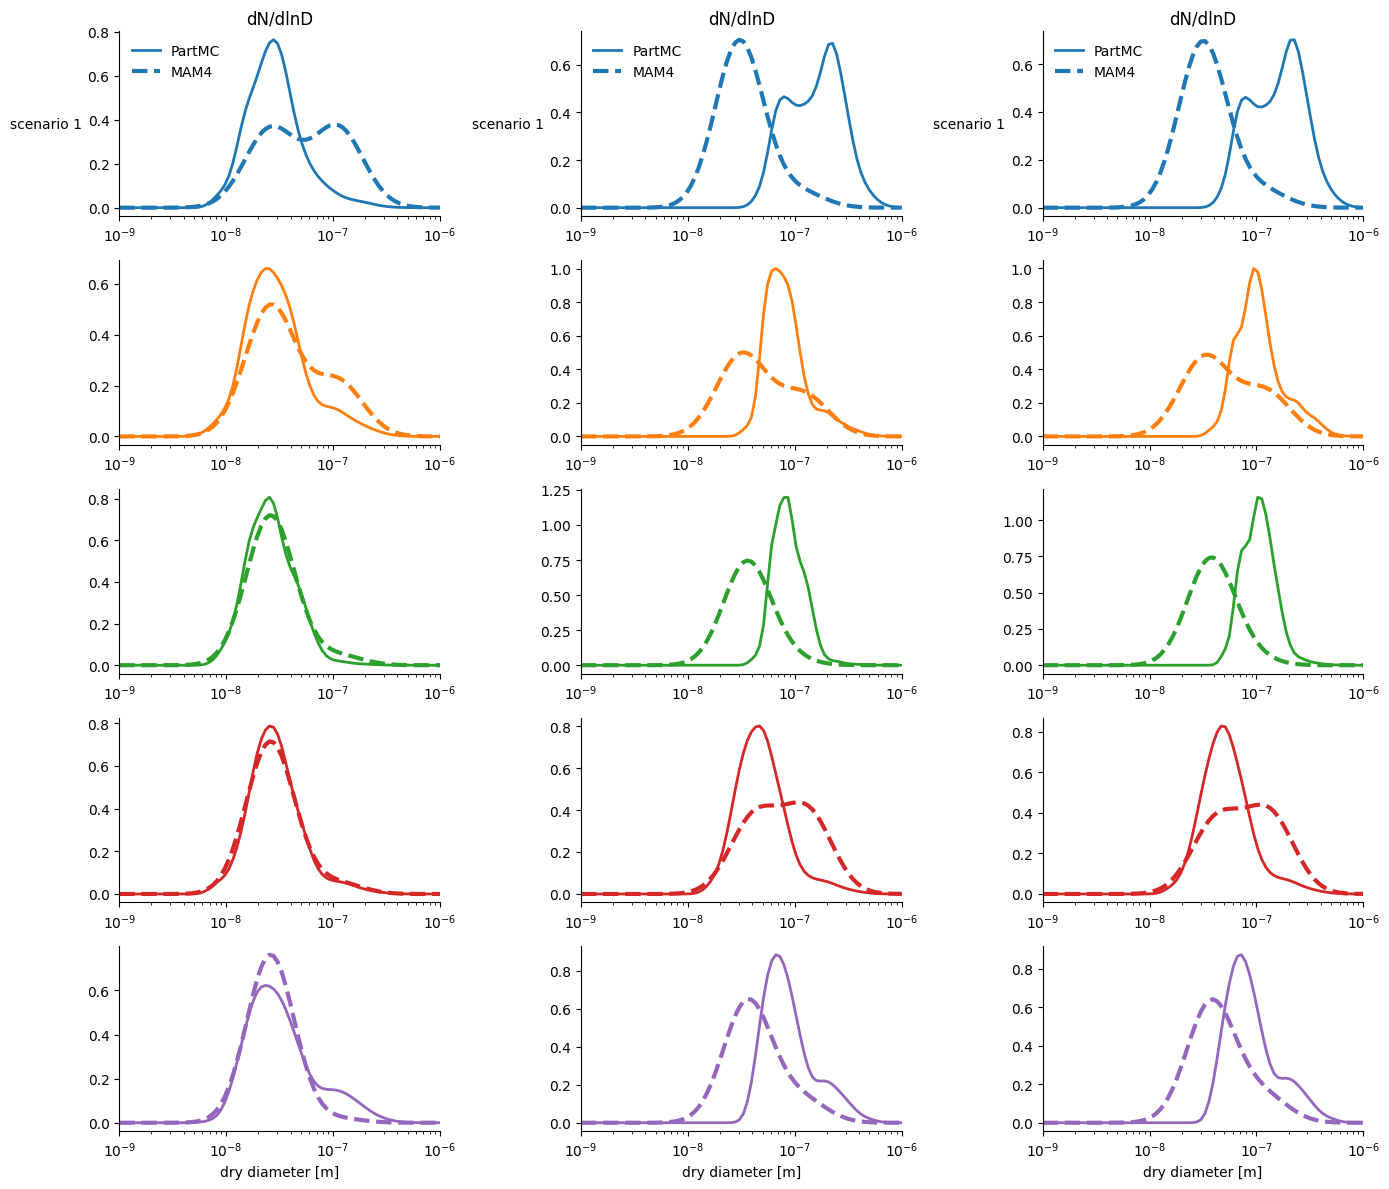

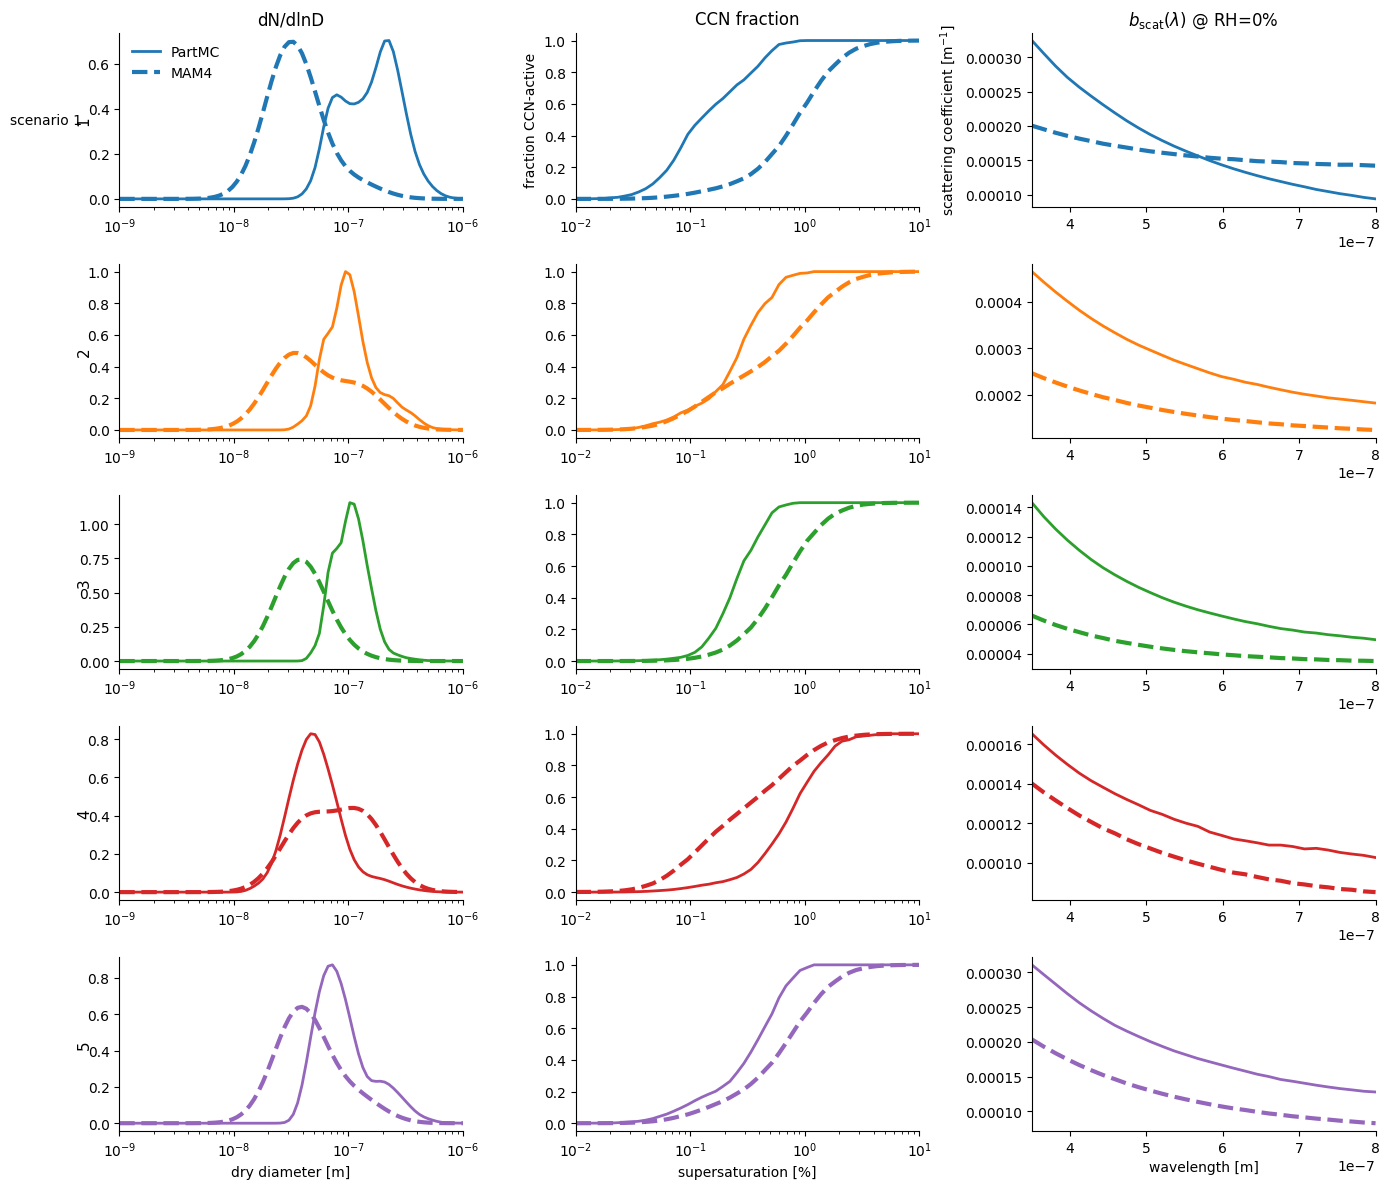

In [ ]:
t_to_plot = 61  # adjust to your file indexing
fig, axes = plot_scenarios_time_evolution(
    ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50,
    # s_grid=np.logspace(-2, 1.0, 50),
    # wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    # RH_for_bscat=np.array([0.0]),
    savepath="scenarios_timeseries.png",
    normalize=False
)

# pick a single timestep to compare (e.g., final index)
t_to_plot = 61  # adjust to your file indexing
fig, axes = plot_scenarios_threecols(
    ensemble, scenario_names, t_to_plot, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50,
    s_grid=np.logspace(-2, 1.0, 50),
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
    RH_for_bscat=np.array([0.0]),
    savepath="scenarios_threecols.png",
    normalize=False
)


In [ ]:
# # pick a single timestep to compare (e.g., final index)
# t_to_plot = 61  # adjust to your file indexing
# fig, axes = plot_scenarios_threecols_plusInitialPSD(
#     ensemble, scenario_names, t_to_plot, partmc_dir, mam4_dir,
#     D_range=(1e-9, 1e-6), N_bins=50,
#     s_grid=np.logspace(-2, 1.0, 50),
#     wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30),
#     RH_for_bscat=np.array([0.0]),
#     savepath="scenarios_fourcols.png",
#     normalize=False
# )


In [ ]:
# # After runs (or even interactively for a subset):
# timesteps = [1, 31, 61]
# scenarios = scenario_names

# # dN/dlnD grid
# fig1, ax1 = plot_grid_dNdlnD(
#     ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
#     D_range=(1e-9, 1e-6), N_bins=50, normalize=False, method="kde",
#     savepath="partmc_mam4_dNdlnD.png",
# )

# # CCN fraction grid
# fig2, ax2 = plot_grid_frac_ccn(
#     ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
#     s_grid=np.logspace(-2, 1., 50),
#     savepath="partmc_mam4_frac_ccn.png",
# )


In [ ]:
# ===========================================================
# Flexible grid renderer (rows=scenarios × cols=user-defined)
# - Accepts a matplotlib.gridspec.GridSpec
# - Works for dNdlnD, frac_ccn, b_scat, etc. via var_cfg builders
# - PartMC solid / MAM4 dashed+thicker; color by scenario (row)
# ===========================================================
from typing import Callable, Iterable, Sequence, Tuple, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter

# -----------------------------------------------------------
# Reuseable: cached state retriever (your original pattern)
# -----------------------------------------------------------
def make_state_retriever(ensemble, partmc_dir, mam4_dir, *, repeat_num=1):
    cache = {}

    def retrieve(scenario_name: str, timestep: int, species_modifications=None):
        key = (scenario_name, int(timestep))
        if key in cache:
            return cache[key]

        idx = int(scenario_name) - 1
        scen = ensemble.member(idx)

        # Assumes `ambrs` is available in your environment
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=scen,
            timestep=timestep,
            repeat_num=repeat_num,
            species_modifications=species_modifications or {},
            ensemble_output_dir=mam4_dir,
        )
        cache[key] = (partmc_output, mam4_output)
        return cache[key]

    return retrieve


# -----------------------------------------------------------
# Styling helpers (row color, solid vs dashed, thicker MAM4)
# -----------------------------------------------------------
def _scenario_colors(n_rows: int, palette=None):
    if palette is not None:
        return palette[:n_rows]
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n_rows)]

def _base_styles():
    # Start from your theme so font/rcParams stay consistent
    mgr = StyleManager(Theme(), deterministic=False)
    return mgr.plan("line", ["partmc", "mam4"])

def _row_styles(base_styles: Dict[str, Dict[str, Any]], color) -> Dict[str, Dict[str, Any]]:
    # PartMC: solid; MAM4: dashed + thicker; both share row color
    return {
        "partmc": {**base_styles["partmc"], "color": color, "linestyle": "-",  "linewidth": 2.0},
        "mam4":   {**base_styles["mam4"],   "color": color, "linestyle": "--", "linewidth": 3.0},
    }

def _format_panel(ax, *, xscale=None):
    if xscale:
        ax.set_xscale(xscale)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# -----------------------------------------------------------
# Column builder pattern
# - You pass a function that, given a column key (e.g., timestep),
#   returns (var_cfg: dict, title: str)
# -----------------------------------------------------------
VarCfgBuilder = Callable[[Any], Tuple[Dict[str, Any], str]]

def make_dNdlnD_cfg_builder(*, D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method=""):
    D_min, D_max = D_range
    D_grid = np.logspace(np.log10(D_min), np.log10(D_max), int(N_bins))

    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        # col_value is commonly the timestep; title can reflect that
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        return ({"D": D_grid, "normalize": normalize, "method": method}, title)
    return builder

def make_frac_ccn_cfg_builder(*, s_grid=np.logspace(-2, 1.0, 50)):
    s = np.asarray(s_grid)
    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        return ({"s_grid": s}, title)
    return builder

def make_bscat_cfg_builder(*, wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30), RH=0.0):
    wl = np.asarray(wavelengths_m).ravel()
    RH_scalar = float(np.asarray(RH).ravel()[0])
    def builder(col_value) -> Tuple[Dict[str, Any], str]:
        title = f"t={col_value-1} min" if isinstance(col_value, (int, np.integer)) else str(col_value)
        # Prefer 'wvl_grid' + 'rh_grid' to match your newer API; callers can change if needed
        return ({"wvl_grid": wl, "rh_grid": np.array([RH_scalar])}, title)
    return builder


# -----------------------------------------------------------
# Core engine: render_variable_grid(...)
# - Uses your retriever + build_plotter("state_line", cfg)
# - Fills the provided GridSpec (must be at least rows×cols big)
# -----------------------------------------------------------
DEFAULT_XSCALE = {
    "dNdlnD"  : "log",
    "frac_ccn": "log",
    "b_scat"  : None,
}

def render_variable_grid(
    gs,                               # matplotlib.gridspec.GridSpec
    *,
    ensemble,
    scenarios: Sequence[str],
    columns: Sequence[Any],           # e.g., timesteps [1, 3, 6] or ["t0","t1",...]
    partmc_dir: str,
    mam4_dir: str,
    varname: str,                     # e.g., "dNdlnD", "frac_ccn", "b_scat"
    build_var_cfg: VarCfgBuilder,     # maps column value -> (var_cfg, title)
    legend_loc: str = "upper left",
    row_label_fmt: str = "scenario {name}",
    row_colors: Sequence[Any] | None = None,
    xscale: str | None = None,        # None -> uses DEFAULT_XSCALE[varname] if present
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Render a grid where rows = scenarios and columns = user-defined 'columns'
    (e.g., timesteps). Draws PartMC vs MAM4 overlays per cell.

    Returns
    -------
    fig, axes : (matplotlib.figure.Figure, np.ndarray[(n_rows, n_cols)])
    """
    fig = gs.figure
    n_rows, n_cols = len(scenarios), len(columns)

    # sanity: GridSpec must be big enough
    if getattr(gs, "nrows", None) is not None and getattr(gs, "ncols", None) is not None:
        if gs.nrows < n_rows or gs.ncols < n_cols:
            raise ValueError(f"GridSpec too small: needs at least {n_rows}×{n_cols}, "
                             f"got {gs.nrows}×{gs.ncols}")

    axes = np.empty((n_rows, n_cols), dtype=object)
    retr = make_state_retriever(ensemble, partmc_dir, mam4_dir)
    base = _base_styles()
    colors = _scenario_colors(n_rows) if row_colors is None else list(row_colors)
    xsc = DEFAULT_XSCALE.get(varname, None) if xscale is None else xscale

    for i, scenario_name in enumerate(scenarios):
        row_style = _row_styles(base, colors[i])

        for j, col_value in enumerate(columns):
            ax = fig.add_subplot(gs[i, j])
            axes[i, j] = ax

            # Pull states once per cell
            partmc_output, mam4_output = retr(scenario_name, col_value)
            series = (
                ("partmc", partmc_output.particle_population, "PartMC"),
                ("mam4",   mam4_output.particle_population,   "MAM4"),
            )

            # Build var_cfg + column title
            var_cfg, col_title = build_var_cfg(col_value)

            # Plot both series
            for key, population, label in series:
                cfg = {"varname": varname, "var_cfg": var_cfg, "style": row_style[key]}
                build_plotter("state_line", cfg).plot(population, ax, label=label)

            # panel cosmetics
            _format_panel(ax, xscale=xsc)

            # column titles (top row only)
            if i == 0 and col_title:
                ax.set_title(col_title)

            # legend (only once)
            if i == 0 and j == 0:
                ax.legend(frameon=False, loc=legend_loc)

            # left-hand row labels (first column)
            if j == 0 and row_label_fmt:
                ax.text(-0.08, 0.5, row_label_fmt.format(name=scenario_name),
                        transform=ax.transAxes, rotation=90, va="center", ha="right", fontsize=11)

            # remove repeated labels inside the grid
            if i < n_rows - 1:
                ax.set_xlabel("")
            if j > 0:
                ax.set_ylabel("")

    fig.canvas.draw_idle()
    return fig, axes


# -----------------------------------------------------------
# Convenience wrappers for common cases
# -----------------------------------------------------------
def render_dNdlnD_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    D_range=(1e-9, 1e-6), N_bins=50, normalize=True, method="",
    legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="dNdlnD",
        build_var_cfg=make_dNdlnD_cfg_builder(
            D_range=D_range, N_bins=N_bins, normalize=normalize, method=method
        ),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

def render_frac_ccn_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    s_grid=np.logspace(-2, 1.0, 50), legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="frac_ccn",
        build_var_cfg=make_frac_ccn_cfg_builder(s_grid=s_grid),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

def render_bscat_vs_time(
    gs, *, ensemble, scenarios, timesteps, partmc_dir, mam4_dir,
    wavelengths_m=np.linspace(0.35e-6, 0.8e-6, 30), RH=0.0, legend_loc="upper left",
):
    return render_variable_grid(
        gs,
        ensemble=ensemble,
        scenarios=scenarios,
        columns=list(timesteps if isinstance(timesteps, Iterable) else [timesteps]),
        partmc_dir=partmc_dir,
        mam4_dir=mam4_dir,
        varname="b_scat",
        build_var_cfg=make_bscat_cfg_builder(wavelengths_m=wavelengths_m, RH=RH),
        legend_loc=legend_loc,
        row_label_fmt="scenario {name}",
    )

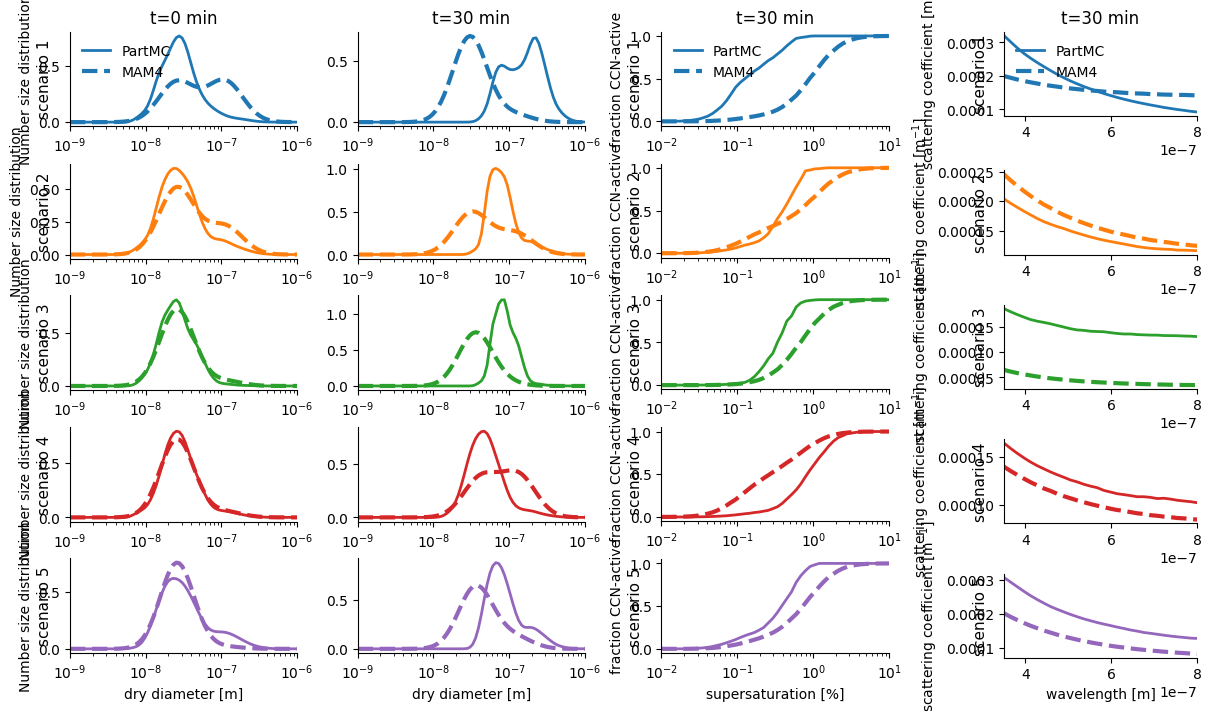

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec as mgs  # <-- for GridSpecFromSubplotSpec

scenarios = ["1","2","3","4","5"]   # rows
timesteps = [1, 31]                 # columns (2 left subcolumns)

fig = plt.figure(constrained_layout=True, figsize=(12, 7))

# Make a 3-column OUTER grid: [DSD block | CCN | SCAT]
# Give the left block width proportional to number of timesteps.
outer = fig.add_gridspec(
    nrows=len(scenarios), ncols=3,
    width_ratios=[len(timesteps), 1, 1],
    hspace=0.1, wspace=0.2
)

# Now make CHILD grids for each block using GridSpecFromSubplotSpec
gs_dsd  = mgs.GridSpecFromSubplotSpec(len(scenarios), len(timesteps), subplot_spec=outer[:, 0])
gs_ccn  = mgs.GridSpecFromSubplotSpec(len(scenarios), 1,              subplot_spec=outer[:, 1])
gs_scat = mgs.GridSpecFromSubplotSpec(len(scenarios), 1,              subplot_spec=outer[:, 2])

# ---- render the left block (dN/dlnD across time)
render_dNdlnD_vs_time(
    gs_dsd,
    # fig=fig,                      # <-- pass fig so the renderer doesn’t need gs.figure
    ensemble=ensemble,
    scenarios=scenarios,
    timesteps=timesteps,          # 2 columns on the left
    partmc_dir=partmc_dir,
    mam4_dir=mam4_dir,
    D_range=(1e-9, 1e-6),
    N_bins=60,
    normalize=True,
    method="kde",
)

render_frac_ccn_vs_time(gs_ccn, #fig=fig, 
                        ensemble=ensemble, scenarios=scenarios,
                        timesteps=[31], partmc_dir=partmc_dir, mam4_dir=mam4_dir)


render_bscat_vs_time(gs_scat, #fig=fig, 
                     ensemble=ensemble, scenarios=scenarios,
                        timesteps=[31], partmc_dir=partmc_dir, mam4_dir=mam4_dir)
plt.show()
